In [10]:
import pandas as pd

# Load the dataset with semicolon as the delimiter
orders = pd.read_csv('orders.csv', sep=';')
print(orders.head())


       order_id origin_port    3pl customs_procedures logistic_hub   customer  \
0  366c7a3d298f   Rotterdam  v_002                DTP        Venlo  Marseille   
1  45f906331e10   Rotterdam  v_004                CRF         Rome  Marseille   
2  ac84a6e4af0f      Athens  v_002                CRF        Venlo      Paris   
3  f5e98cb29790   Rotterdam  v_004                CRF        Lille      Milan   
4  a9e7c9bee35b   Barcelona  v_002                CRF        Venlo     Berlin   

   product_id  units  late_order  
0     1692723    583        True  
1     1644308    459       False  
2     1684170    464        True  
3     1620510    678       False  
4     1699372    353       False  


In [11]:
orders.head(3)

,order_id,origin_port,3pl,customs_procedures,logistic_hub,customer,product_id,units,late_order
0,366c7a3d298f,Rotterdam,v_002,DTP,Venlo,Marseille,1692723,583,True
1,45f906331e10,Rotterdam,v_004,CRF,Rome,Marseille,1644308,459,False
2,ac84a6e4af0f,Athens,v_002,CRF,Venlo,Paris,1684170,464,True


In [14]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114276 entries, 0 to 114275
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   order_id            114276 non-null  object
 1   origin_port         114276 non-null  object
 2   3pl                 114276 non-null  object
 3   customs_procedures  114276 non-null  object
 4   logistic_hub        113227 non-null  object
 5   customer            114276 non-null  object
 6   product_id          114276 non-null  int64 
 7   units               114276 non-null  int64 
 8   late_order          114276 non-null  bool  
dtypes: bool(1), int64(2), object(6)
memory usage: 7.1+ MB


In [16]:
products = pd.read_csv('product_attributes.csv')
cities = pd.read_csv('cities_data.csv',sep=';')

# Display the first few rows of each dataset
print(products.head(5))
print(cities.head(5))

   product_id  weight  material_handling
0     1672707    2876                  3
1     1694456    2785                  5
2     1682865    2751                  3
3     1689146    2736                  0
4     1664069    2707                  4
  city_from_name city_to_name          city_from_coord  \
0     Dusseldorf     Zaragoza  (51.2254018, 6.7763137)   
1     Dusseldorf        Venlo  (51.2254018, 6.7763137)   
2     Dusseldorf   Bratislava  (51.2254018, 6.7763137)   
3     Dusseldorf      Hamburg  (51.2254018, 6.7763137)   
4     Dusseldorf         Rome  (51.2254018, 6.7763137)   

                       city_to_coord   distance  
0           (41.6521342, -0.8809428)  1214.4772  
1  (51.39244885, 6.1511724144122955)    47.3876  
2           (48.1516988, 17.1093063)   819.2894  
3             (53.550341, 10.000654)   339.2215  
4           (41.8933203, 12.4829321)  1125.0290  


<Axes: xlabel='late_order'>

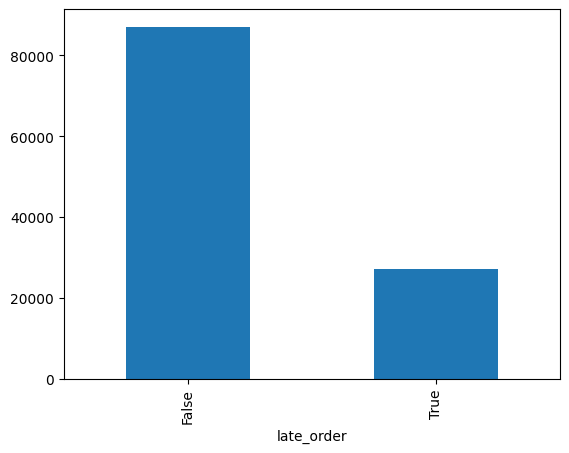

In [17]:
# Check the distribution of late orders
orders['late_order'].value_counts().plot(kind='bar')

In [18]:
# Group by third-party logistics company (3pl) to see if some companies have more late deliveries
late_by_3pl = orders.groupby('3pl')['late_order'].mean().sort_values(ascending=False)
print(late_by_3pl)

3pl
v_001    0.382099
v_004    0.256949
v_003    0.250252
v_002    0.199447
Name: late_order, dtype: float64


In [19]:
# Analyze order sizes and their impact on delays
late_by_units = orders.groupby('units')['late_order'].mean()
print(late_by_units)

units
1      1.0
45     0.0
87     1.0
96     0.0
99     1.0
      ... 
849    1.0
858    1.0
876    0.0
880    1.0
951    1.0
Name: late_order, Length: 665, dtype: float64


In [21]:
# Example of coordinates in string format: '52.3676, 4.9041'
def parse_coordinates(coord_str):
    try:
        lat, lon = map(float, coord_str.split(','))
        return (lat, lon)
    except:
        return None  # Return None if the format is incorrect

# Convert coordinates to tuples in both 'city_from_coord' and 'city_to_coord'
cities['city_from_coord'] = cities['city_from_coord'].apply(parse_coordinates)
cities['city_to_coord'] = cities['city_to_coord'].apply(parse_coordinates)


In [22]:
from geopy.distance import geodesic

def calculate_distance(row):
    if row['city_from_coord'] and row['city_to_coord']:
        return geodesic(row['city_from_coord'], row['city_to_coord']).km
    else:
        return None  # Return None if coordinates are missing

cities['distance'] = cities.apply(calculate_distance, axis=1)


In [23]:
# Merge city data into orders data
orders = orders.merge(cities, left_on=['origin_port', 'customer'], right_on=['city_from_name', 'city_to_name'], how='left')


In [24]:
# Merge product attributes
orders = orders.merge(products, on='product_id', how='left')


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Prepare the dataset for modeling
X = orders[['units', 'weight', 'distance', 'material_handling']]  # Add relevant features
y = orders['late_order']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model using ROC-AUC
auc = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC Score: {auc}")


ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [51]:
# Check for missing values in the selected features
print(orders[['units', 'weight', 'distance', 'material_handling']].isnull().sum())


units                     0
weight                  118
distance             114276
material_handling       118
dtype: int64


In [52]:
X = orders[['units', 'weight', 'distance', 'material_handling']].dropna()
y = orders.loc[X.index, 'late_order']  # Ensure y matches the rows of X


In [54]:
# Fill missing values with the mean for numerical features
X = orders[['units', 'weight', 'distance', 'material_handling']].fillna(orders[['units', 'weight', 'distance', 'material_handling']].mean())
y = orders['late_order']  # You can use the original y, as it's not affected


In [55]:
# Check for remaining missing values
print(X.isnull().sum())


units                     0
weight                    0
distance             114276
material_handling         0
dtype: int64


In [56]:
missing_distance_info = orders[orders['distance'].isnull()][['origin_port', 'customer']].value_counts()
print(missing_distance_info)


origin_port  customer
Rotterdam    Berlin      5532
             Milan       5523
             Madrid      5244
             Vienna      3986
             Paris       3757
                         ... 
BCN          Porto         24
ATHENAS      Bordeaux      24
             Turin         24
             Valencia      21
             Porto         17
Name: count, Length: 140, dtype: int64


In [59]:
# Fill missing distances with the mean or median
mean_distance = orders['distance'].mean()
orders['distance'].fillna(mean_distance, inplace=True)


In [60]:
print(X.isnull().sum())

units                     0
weight                    0
distance             114276
material_handling         0
dtype: int64


 LogisticRegression from scikit-learn cannot handle missing values (NaNs) in  dataset directly. I tried to handle the missing values but for distance it was not suiable so i used alternative option HistGradientBoostingRegressor, which can handle NaN values directly.

In [61]:
from sklearn.ensemble import HistGradientBoostingClassifier

# Define your features and target variable
X = orders[['units', 'weight', 'distance', 'material_handling']]
y = orders['late_order']

# Create and train the model
model = HistGradientBoostingClassifier()
model.fit(X, y)


HistGradientBoostingClassifier()

In [62]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [63]:
model.fit(X_train, y_train)


HistGradientBoostingClassifier()

In [65]:
y_pred = model.predict(X_test)


In [66]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Print classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)


Accuracy: 0.80
Confusion Matrix:
 [[16935   580]
 [ 3949  1392]]
Classification Report:
               precision    recall  f1-score   support

       False       0.81      0.97      0.88     17515
        True       0.71      0.26      0.38      5341

    accuracy                           0.80     22856
   macro avg       0.76      0.61      0.63     22856
weighted avg       0.79      0.80      0.76     22856



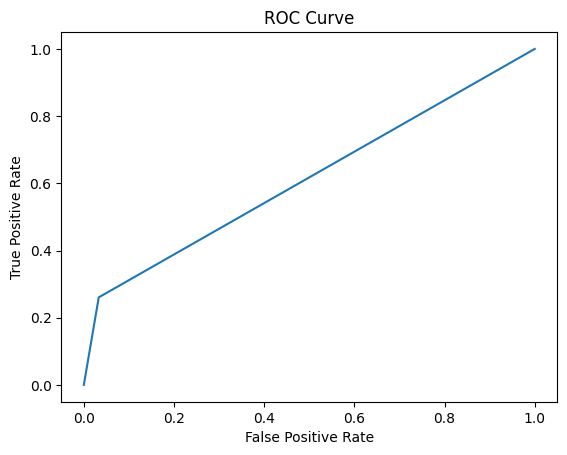

In [67]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label="Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()


In [68]:
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test)
auc_rf = roc_auc_score(y_test, y_pred_rf)
print(f"Random Forest ROC-AUC Score: {auc_rf}")


Random Forest ROC-AUC Score: 0.6190940089707258
